<a href="https://colab.research.google.com/github/kitigai/RLPlactice/blob/master/cartPole_DeepQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import gym
import numpy as np
import random
import pandas

from __future__ import absolute_import, division, print_function

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

In [0]:


class QLearn:
    def __init__(self, actions, epsilon, alpha, gamma, iterations):
      self.q = {}
      self.epsilon = epsilon  # exploration constant
      self.alpha = alpha      # discount constant
      self.gamma = gamma      # discount factor
      self.actions = actions
      self.exploration_delta = epsilon / iterations
    def defineModel(self):
      
      self.model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(4,)),
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dense(2, activation=tf.nn.softmax)
      ])
      
      self.model.compile(optimizer='adam', 
              loss='mse',
              metrics=['accuracy'])
      
      
    def getQ(self, state):
      #print(state.shape)
      return self.model.predict(state)
    def learnQ(self, state, action, reward, nextState):
      initialQ = self.getQ(state)
      nextQ = self.getQ(state)
      #print(action)
      #print(initialQ.shape)
      initialQ[0][action] = reward + self.gamma*np.amax(nextQ)
      
      self.model.fit(state, initialQ, verbose=0)
      #if initialQ is None:
      #  self.q[(state, action)] = reward
      #else:
      #  nextAction = self.greedyAction(nextState)
      #  nextQ = self.getQ(nextState, nextAction)
      #  self.q[(state, action)] = initialQ + self.alpha * ( reward + self.gamma*nextQ - initialQ)
    def getNextAction(self, state):
      if random.random() > self.epsilon:
        return self.greedyAction(state)
      else:
        return self.randomAction()
    def greedyAction(self, state):
      #qInstate = [self.getQ(state, a) for a in self.actions]
      #print(qInstate)
      #maxQ = max(qInstate)
      #maxQIndex = max(qInstate.items(), lambda x:x[1])[0][1]
      #maxQIndex = self.actions[qInstate.index(maxQ)]
      return np.argmax(self.getQ(state))

    def randomAction(self):
      return random.choice(self.actions)
    def reduceEpsilon(self):
      self.epsilon -= self.exploration_delta
    
    
      


In [0]:
def build_state(features):
    return int("".join(map(lambda feature: str(int(feature)), features)))

def to_bin(value, bins):
    return numpy.digitize(x=[value], bins=bins)[0]

In [0]:
env = gym.make('CartPole-v0')
goal_average_steps = 195
max_number_of_steps = 200
last_time_steps = np.ndarray(0)
n_bins = 10
n_bins_angle = 10
iterations = 3000

number_of_features = env.observation_space.shape[0]
last_time_steps = np.ndarray(0)
mean_steps = np.ndarray(0)
# Number of states is huge so in order to simplify the situatio
# we discretize the space to: 10 ** number_of_features
cart_position_bins = pandas.cut([-2.4, 2.4], bins=n_bins, retbins=True)[1][1:-1]
pole_angle_bins = pandas.cut([-41.8, 41.8], bins=n_bins_angle, retbins=True)[1][1:-1]
cart_velocity_bins = pandas.cut([-1, 1], bins=n_bins, retbins=True)[1][1:-1]
pole_velocity_bins = pandas.cut([-3.5, 3.5], bins=n_bins_angle, retbins=True)[1][1:-1]

# The Q-learn algorithm
qlearn = QLearn(actions=range(env.action_space.n),
                alpha=0.5, gamma=0.90, epsilon=0.1, iterations=iterations)
qlearn.defineModel()
for step in range(iterations):
  observation = env.reset()
  cart_position, cart_velocity, pole_angle, pole_velocity = observation

  for t in range(max_number_of_steps):
    #print(observation.shape)
    old_observation = observation
    #print(old_observation.shape)
    action = qlearn.getNextAction(old_observation.reshape(1,len(old_observation)))
    new_observation, reward, done, info = env.step(action)
    #cart_position, cart_velocity, pole_angle, pole_velocity = observation
    #nextState = build_state([to_bin(cart_position, cart_position_bins),
     #                  to_bin(cart_velocity, cart_velocity_bins),
      #                 to_bin(pole_angle, pole_angle_bins),
       #                to_bin(pole_velocity, pole_velocity_bins)])
    if not(done):
      qlearn.learnQ(old_observation.reshape(1,len(old_observation)), action, reward, new_observation.reshape(1,len(new_observation)))
      observation = new_observation
    else:
      reward = -200
      qlearn.learnQ(old_observation.reshape(1,len(old_observation)), action , reward, new_observation.reshape(1,len(new_observation)))
      last_time_steps = np.append(last_time_steps, [int(t + 1)])
      break
  
  mean_steps = np.append(mean_steps,last_time_steps.mean())
  last_time_steps = np.ndarray(0)
  qlearn.reduceEpsilon()


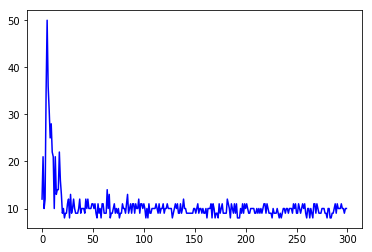

In [0]:
import matplotlib.pyplot as plt

l = mean_steps.tolist()[0:9999:10]
plt.plot(range(len(l)), l, "b", label = "survive steps")
plt.show()

         